In [12]:
# EDA: Statistical summaries and univariate distributions for claims_train.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textwrap import dedent

In [13]:
df = pd.read_csv("./data/claims_train.csv")


info_table = pd.DataFrame({
    "n_rows": [len(df)],
    "n_cols": [df.shape[1]],
    "n_numeric": [df.select_dtypes(include=[np.number]).shape[1]],
    "n_categorical": [df.select_dtypes(exclude=[np.number]).shape[1]],
    "missing_total": [df.isna().sum().sum()]
})

info_table

,n_rows,n_cols,n_numeric,n_categorical,missing_total
0,542410,12,8,4,0


In [14]:
# Missingness by column
missing_by_col = df.isna().sum().rename("missing_count").to_frame()
missing_by_col["missing_pct"] = (missing_by_col["missing_count"] / len(df)).round(6)

In [15]:
# Summary stats (numeric + categorical)
summary_numeric = df.describe().T
summary_categorical = df.describe(include="object").T

In [16]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("./data/claims_train.csv")

# -----------------------------
# Create the summary tables
# -----------------------------
info_table = pd.DataFrame({
    "n_rows": [len(df)],
    "n_cols": [df.shape[1]],
    "n_numeric": [df.select_dtypes(include=[np.number]).shape[1]],
    "n_categorical": [df.select_dtypes(exclude=[np.number]).shape[1]],
    "missing_total": [df.isna().sum().sum()]
})

# Missingness by column
missing_by_col = df.isna().sum().rename("missing_count").to_frame()
missing_by_col["missing_pct"] = (missing_by_col["missing_count"] / len(df)).round(6)

# Summary stats
summary_numeric = df.describe().T
summary_categorical = df.describe(include="object").T

# -----------------------------
# Display tables WITHOUT caas_jupyter_tools
# -----------------------------
print("\n=== Dataset Info ===")
print(info_table.to_string(index=False))

print("\n=== Missingness by Column ===")
print(missing_by_col.to_string())

print("\n=== Numeric Summary (describe) ===")
print(summary_numeric.round(3).to_string())

print("\n=== Categorical Summary (describe) ===")
print(summary_categorical.to_string())



=== Dataset Info ===
 n_rows  n_cols  n_numeric  n_categorical  missing_total
 542410      12          8              4              0

=== Missingness by Column ===
            missing_count  missing_pct
IDpol                   0          0.0
ClaimNb                 0          0.0
Exposure                0          0.0
Area                    0          0.0
VehPower                0          0.0
VehAge                  0          0.0
DrivAge                 0          0.0
BonusMalus              0          0.0
VehBrand                0          0.0
VehGas                  0          0.0
Density                 0          0.0
Region                  0          0.0

=== Numeric Summary (describe) ===
               count         mean          std     min         25%         50%         75%         max
IDpol       542410.0  2623260.277  1641808.916   1.000  1158401.25  2272433.50  4046605.50  6114330.00
ClaimNb     542410.0        0.053        0.239   0.000        0.00        0.00      

In [17]:
# Claim occurrence (binary)
df["ClaimOccur"] = (df["ClaimNb"] > 0).astype(int)

# Claim rate per year (handle Exposure == 0 safely)
df["ClaimRate"] = np.where(df["Exposure"] > 0, df["ClaimNb"] / df["Exposure"], np.nan)

In [18]:
# Helper plotting functions

def hist_plot(series, bins=50, title="", xlabel="", xlim=None, logy=False):
    plt.figure(figsize=(7, 4))
    plt.hist(series.dropna().values, bins=bins)
    if xlim is not None:
        plt.xlim(xlim)
    if logy:
        plt.yscale("log")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def bar_topn(series, topn=20, title="", xlabel="Category", ylabel="Count", rotate=45):
    counts = series.value_counts().head(topn)
    plt.figure(figsize=(8, 4))
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotate, ha="right")
    plt.tight_layout()
    plt.show()

Target variables

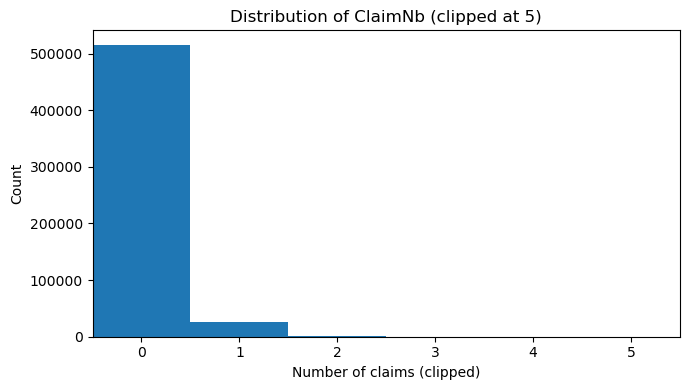

In [19]:
# ClaimNb distribution (clip x-axis for readability)
max_claim_cap = 5  # visualize up to 5 claims; very few beyond that
hist_plot(
    series=df["ClaimNb"].clip(upper=max_claim_cap),
    bins=np.arange(-0.5, max_claim_cap + 1.5, 1),
    title="Distribution of ClaimNb (clipped at 5)",
    xlabel="Number of claims (clipped)",
    xlim=(-0.5, max_claim_cap + 0.5),
    logy=False
)

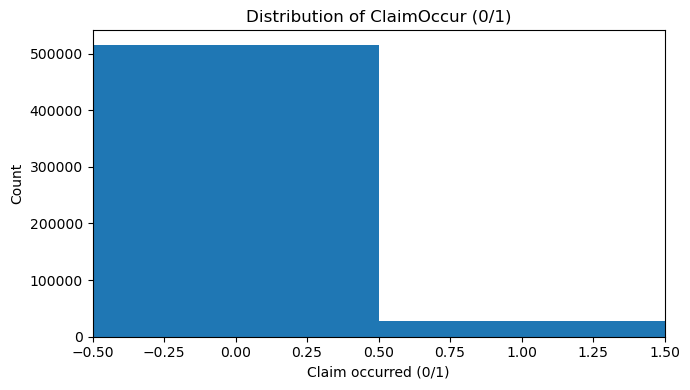

In [20]:
# Claim occurrence rate
hist_plot(
    series=df["ClaimOccur"],
    bins=np.arange(-0.5, 2, 1),
    title="Distribution of ClaimOccur (0/1)",
    xlabel="Claim occurred (0/1)",
    xlim=(-0.5, 1.5),
    logy=False
)

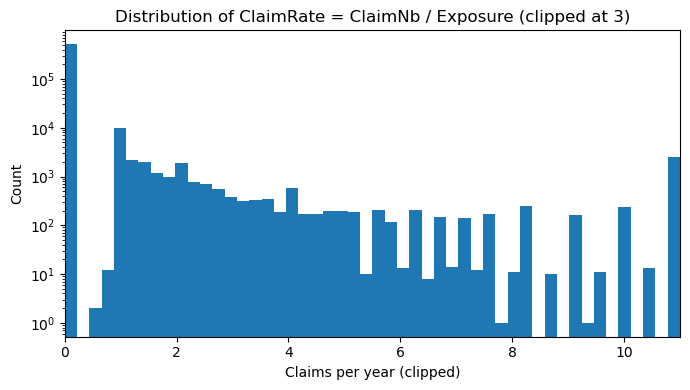

In [21]:

# ClaimRate distribution (clip extreme rates for visibility)
rate_clip = df["ClaimRate"].dropna().clip(upper=11)  # cap extreme outliers
hist_plot(
    series=rate_clip,
    bins=50,
    title="Distribution of ClaimRate = ClaimNb / Exposure (clipped at 3)",
    xlabel="Claims per year (clipped)",
    xlim=(0, 11),
    logy=True  # often heavy tail
    )

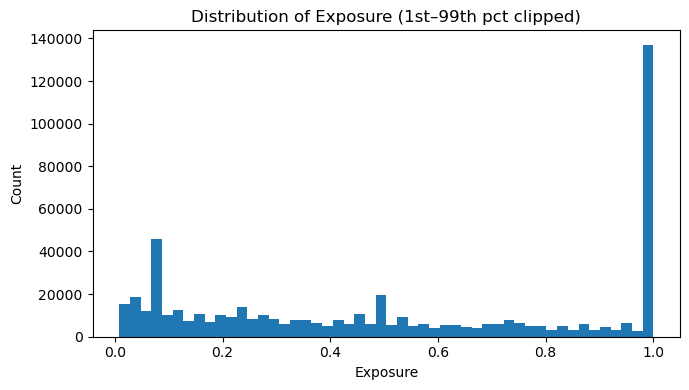

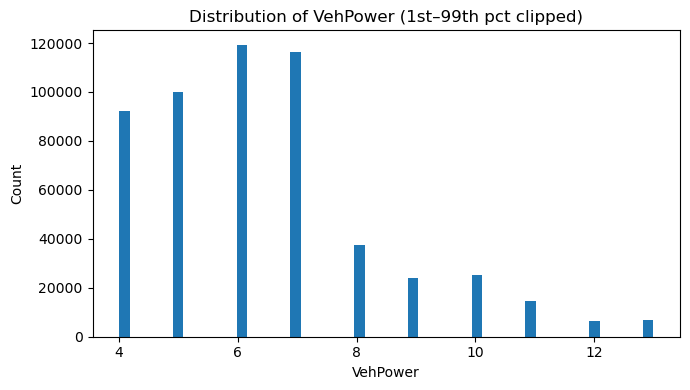

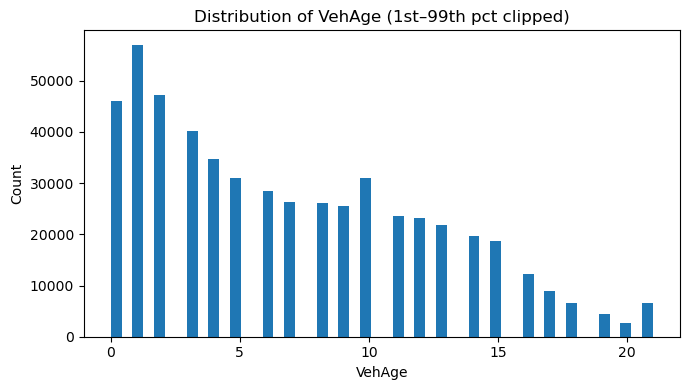

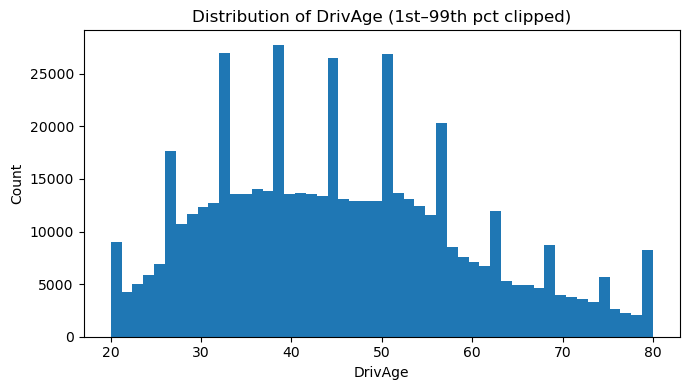

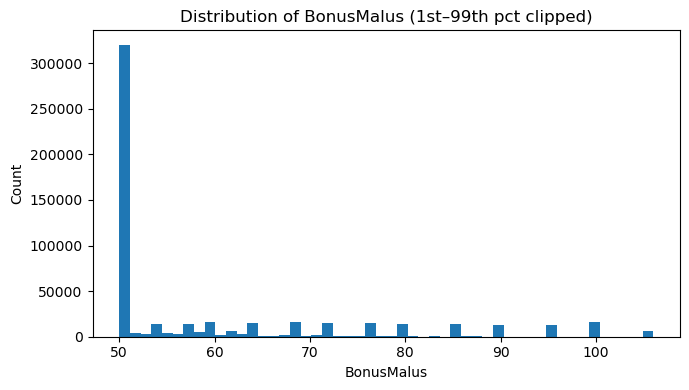

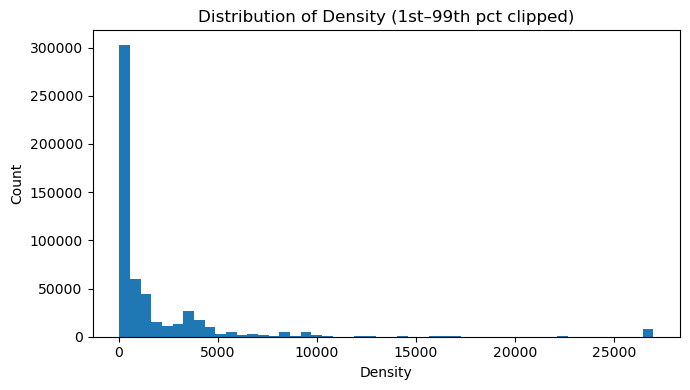

In [22]:
# Numeric feature distributions
numeric_cols = ["Exposure", "VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]

for col in numeric_cols:
    # sensible caps for visibility
    series = df[col].astype(float)
    # dynamic clipping: cap at 99th percentile for readability
    upper = np.nanpercentile(series, 99)
    lower = np.nanpercentile(series, 1)
    clipped = series.clip(lower=lower, upper=upper)
    hist_plot(
        series=clipped,
        bins=50,
        title=f"Distribution of {col} (1st–99th pct clipped)",
        xlabel=col,
        logy=False
    )

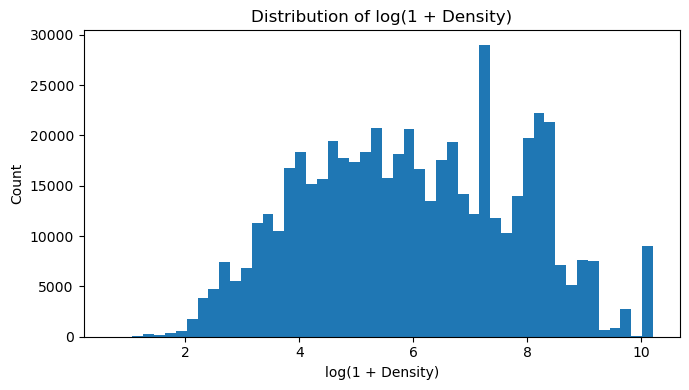

In [23]:
# log-scale density to show long tail structure
density_pos = df.loc[df["Density"] > 0, "Density"].astype(float)
hist_plot(
    series=np.log1p(density_pos),
    bins=50,
    title="Distribution of log(1 + Density)",
    xlabel="log(1 + Density)",
    logy=False
)

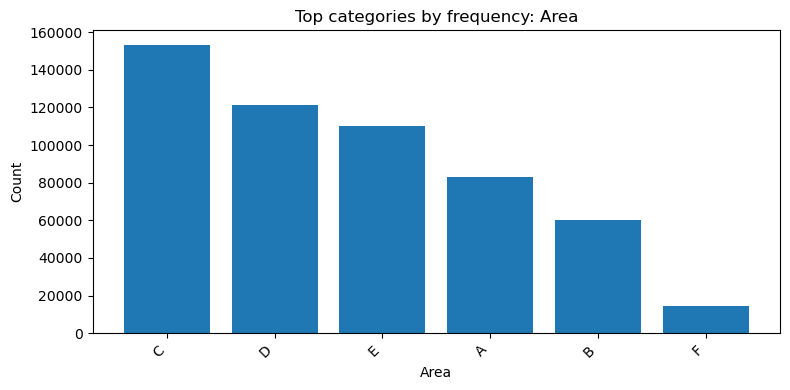

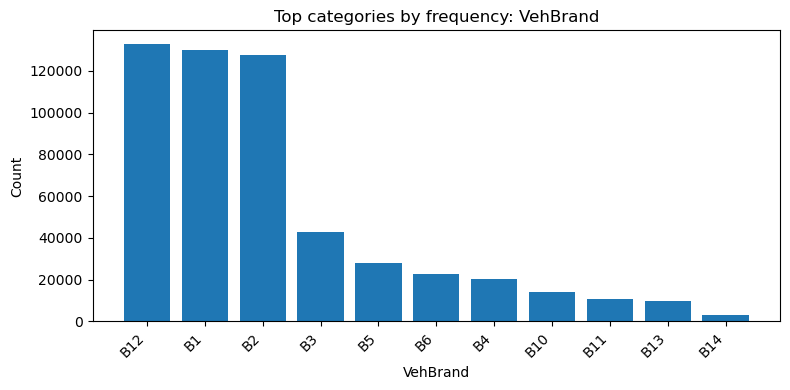

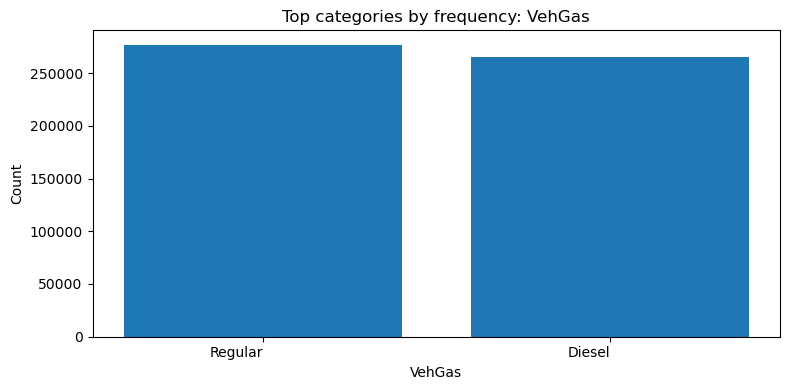

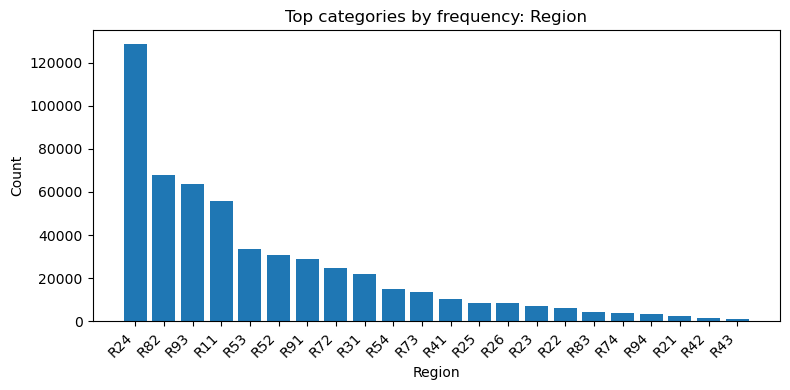

In [24]:
#Categorical feature frequencies
categorical_cols = ["Area", "VehBrand", "VehGas", "Region"]

for col in categorical_cols:
    bar_topn(
        series=df[col].astype(str),
        topn=50 if col == "Region" else 20,  # Region has many levels
        title=f"Top categories by frequency: {col}",
        xlabel=col,
        ylabel="Count",
        rotate=0 if col in ["VehGas"] else 45
    )

In [25]:
# Export a compact EDA summary report (CSV)
# -----------------------------
compact_summary = pd.DataFrame({
    "feature": df.columns,
    "dtype": [df[c].dtype for c in df.columns],
    "n_unique": [df[c].nunique() for c in df.columns],
    "n_missing": [df[c].isna().sum() for c in df.columns]
})
compact_path = "./data/eda_compact_summary.csv"
compact_summary.to_csv(compact_path, index=False)

In [27]:

df = pd.read_csv("./data/claims_train.csv")

print("\n======================")
print(" FEATURE RANGE CHECKS ")
print("======================\n")

# 1. Exposure (should be between 0 and 1)
print("Exposure – expected range: [0, 1]")
print("Min:", df["Exposure"].min(), " Max:", df["Exposure"].max())
print("Invalid (<0):", (df["Exposure"] < 0).sum())
print("Invalid (>1):", (df["Exposure"] > 1).sum(), "\n")

# 2. ClaimNb (should be non-negative integer; typically small counts)
print("ClaimNb – expected: integer >= 0")
print("Min:", df["ClaimNb"].min(), " Max:", df["ClaimNb"].max())
print("Non-integer values:", (~(df["ClaimNb"] % 1 == 0)).sum())
print("Negative values:", (df["ClaimNb"] < 0).sum(), "\n")

# 3. VehPower (usually between 1 and ~15)
print("VehPower – expected: 1 to ~15")
print("Min:", df["VehPower"].min(), " Max:", df["VehPower"].max(), "\n")

# 4. VehAge (usually 0 to ~20)
print("VehAge – expected: 0 to ~20")
print("Min:", df["VehAge"].min(), " Max:", df["VehAge"].max(), "\n")

# 5. DrivAge (usually 18 to ~100)
print("DrivAge – expected: 18 to ~100")
print("Min:", df["DrivAge"].min(), " Max:", df["DrivAge"].max())
print("Under 18:", (df["DrivAge"] < 18).sum(), "\n")

# 6. BonusMalus (French scoring system, usually between 50 and 350)
print("BonusMalus – expected: ~50 to ~350")
print("Min:", df["BonusMalus"].min(), " Max:", df["BonusMalus"].max())
print("Below 50:", (df["BonusMalus"] < 50).sum())
print("Above 350:", (df["BonusMalus"] > 350).sum(), "\n")

# 7. Density (population density; typically >0)
print("Density – expected: positive integer")
print("Min:", df["Density"].min(), " Max:", df["Density"].max())
print("Zero or negative:", (df["Density"] <= 0).sum(), "\n")

# 8. Area (categorical – expected A–F)
print("Area values:", sorted(df["Area"].unique()), "\n")

# 9. VehGas (categorical – expected: Regular, Diesel)
print("VehGas values:", df["VehGas"].unique(), "\n")

# 10. VehBrand (categorical – anonymized B1,...)
print("VehBrand samples:", df["VehBrand"].unique()[:10], "\n")

# 11. Region (categorical – expected Rxx format)
print("Region samples:", df["Region"].unique()[:10], "\n")

print("=== Sanity check complete ===")



 FEATURE RANGE CHECKS 

Exposure – expected range: [0, 1]
Min: 0.00273224  Max: 2.01
Invalid (<0): 0
Invalid (>1): 994 

ClaimNb – expected: integer >= 0
Min: 0  Max: 11
Non-integer values: 0
Negative values: 0 

VehPower – expected: 1 to ~15
Min: 4  Max: 15 

VehAge – expected: 0 to ~20
Min: 0  Max: 100 

DrivAge – expected: 18 to ~100
Min: 18  Max: 100
Under 18: 0 

BonusMalus – expected: ~50 to ~350
Min: 50  Max: 230
Below 50: 0
Above 350: 0 

Density – expected: positive integer
Min: 1  Max: 27000
Zero or negative: 0 

Area values: ['A', 'B', 'C', 'D', 'E', 'F'] 

VehGas values: ['Regular' 'Diesel'] 

VehBrand samples: ['B1' 'B2' 'B6' 'B13' 'B11' 'B5' 'B12' 'B3' 'B10' 'B4'] 

Region samples: ['R24' 'R25' 'R82' 'R53' 'R54' 'R11' 'R94' 'R93' 'R91' 'R52'] 

=== Sanity check complete ===


In [30]:
(df["VehAge"] > 25).sum()

2055

In [29]:
(df["VehAge"] > 50).sum()


77

In [39]:

"""Print all rows where Exposure > 1."""
bad_rows = df[df["Exposure"] > 1]
print(f"Number of rows with Exposure > 1: {len(bad_rows)}\n")
print(bad_rows)


Number of rows with Exposure > 1: 994

            IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  \
272     1196421.0        0      1.03    D         6       4       51   
1298    1194562.0        0      1.01    C        15       0       44   
1767    2261449.0        0      1.06    B         7       1       66   
1990    1195469.0        0      1.01    C         6       8       43   
2209    2270505.0        0      1.03    D         5       3       25   
...           ...      ...       ...  ...       ...     ...      ...   
536377  1198636.0        0      1.22    D         5       3       40   
536528  1181521.0        0      1.03    C        10      13       64   
536884  1196669.0        0      1.18    D         7      14       36   
541133  1197338.0        0      1.15    E         6       2       42   
542091  2258734.0        0      1.02    E         6      12       61   

        BonusMalus VehBrand   VehGas  Density Region  
272             50       B2   Diesel     

In [44]:
import pandas as pd

# Load original dataset
df = pd.read_csv("./data/claims_train.csv")

# Remove rows with Exposure > 1
df_clean = df[df["Exposure"] <= 1].copy()

# Additional engineered feature 
df_clean["ClaimRate"] = np.where(df_clean["Exposure"] > 0, 
                           df_clean["ClaimNb"] / df_clean["Exposure"], np.nan)

numeric_cols = ["ClaimNb", "Exposure", "VehPower", "VehAge",
                "DrivAge", "BonusMalus", "Density"]

numeric_cols.append("ClaimRate")

# Save cleaned dataset
output_path = "./data/claims_train_clean.csv"
df_clean.to_csv(output_path, index=False)

print("Original rows:", len(df))
print("Cleaned rows:", len(df_clean))
print(f"Cleaned dataset saved to: {output_path}")


Original rows: 542410
Cleaned rows: 541416
Cleaned dataset saved to: ./data/claims_train_clean.csv


Correlationship analisys

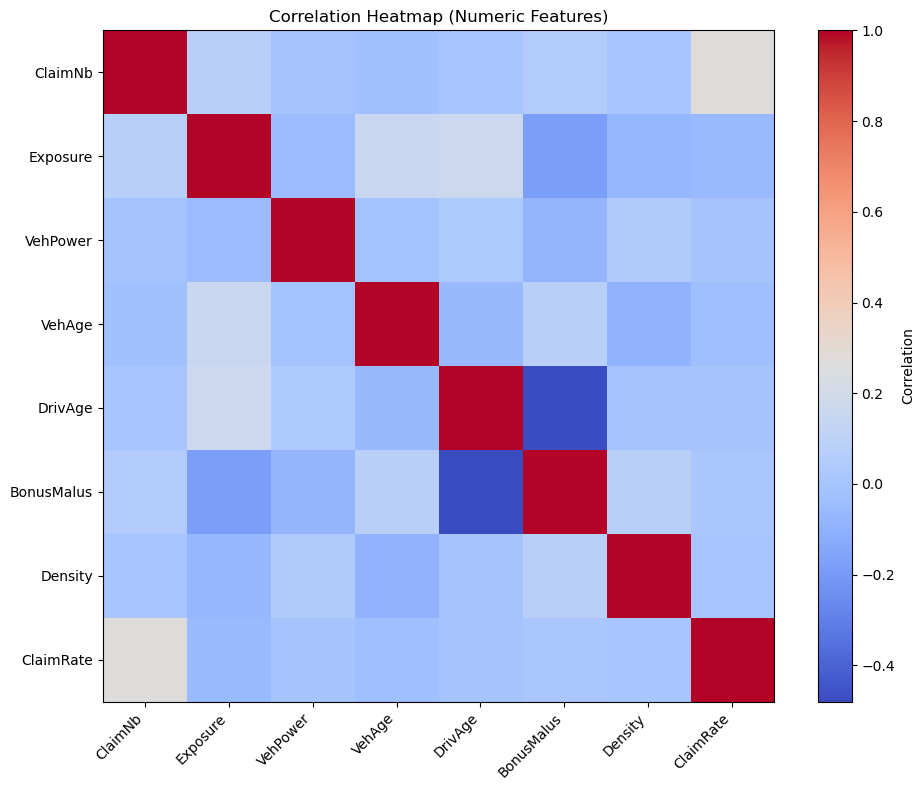

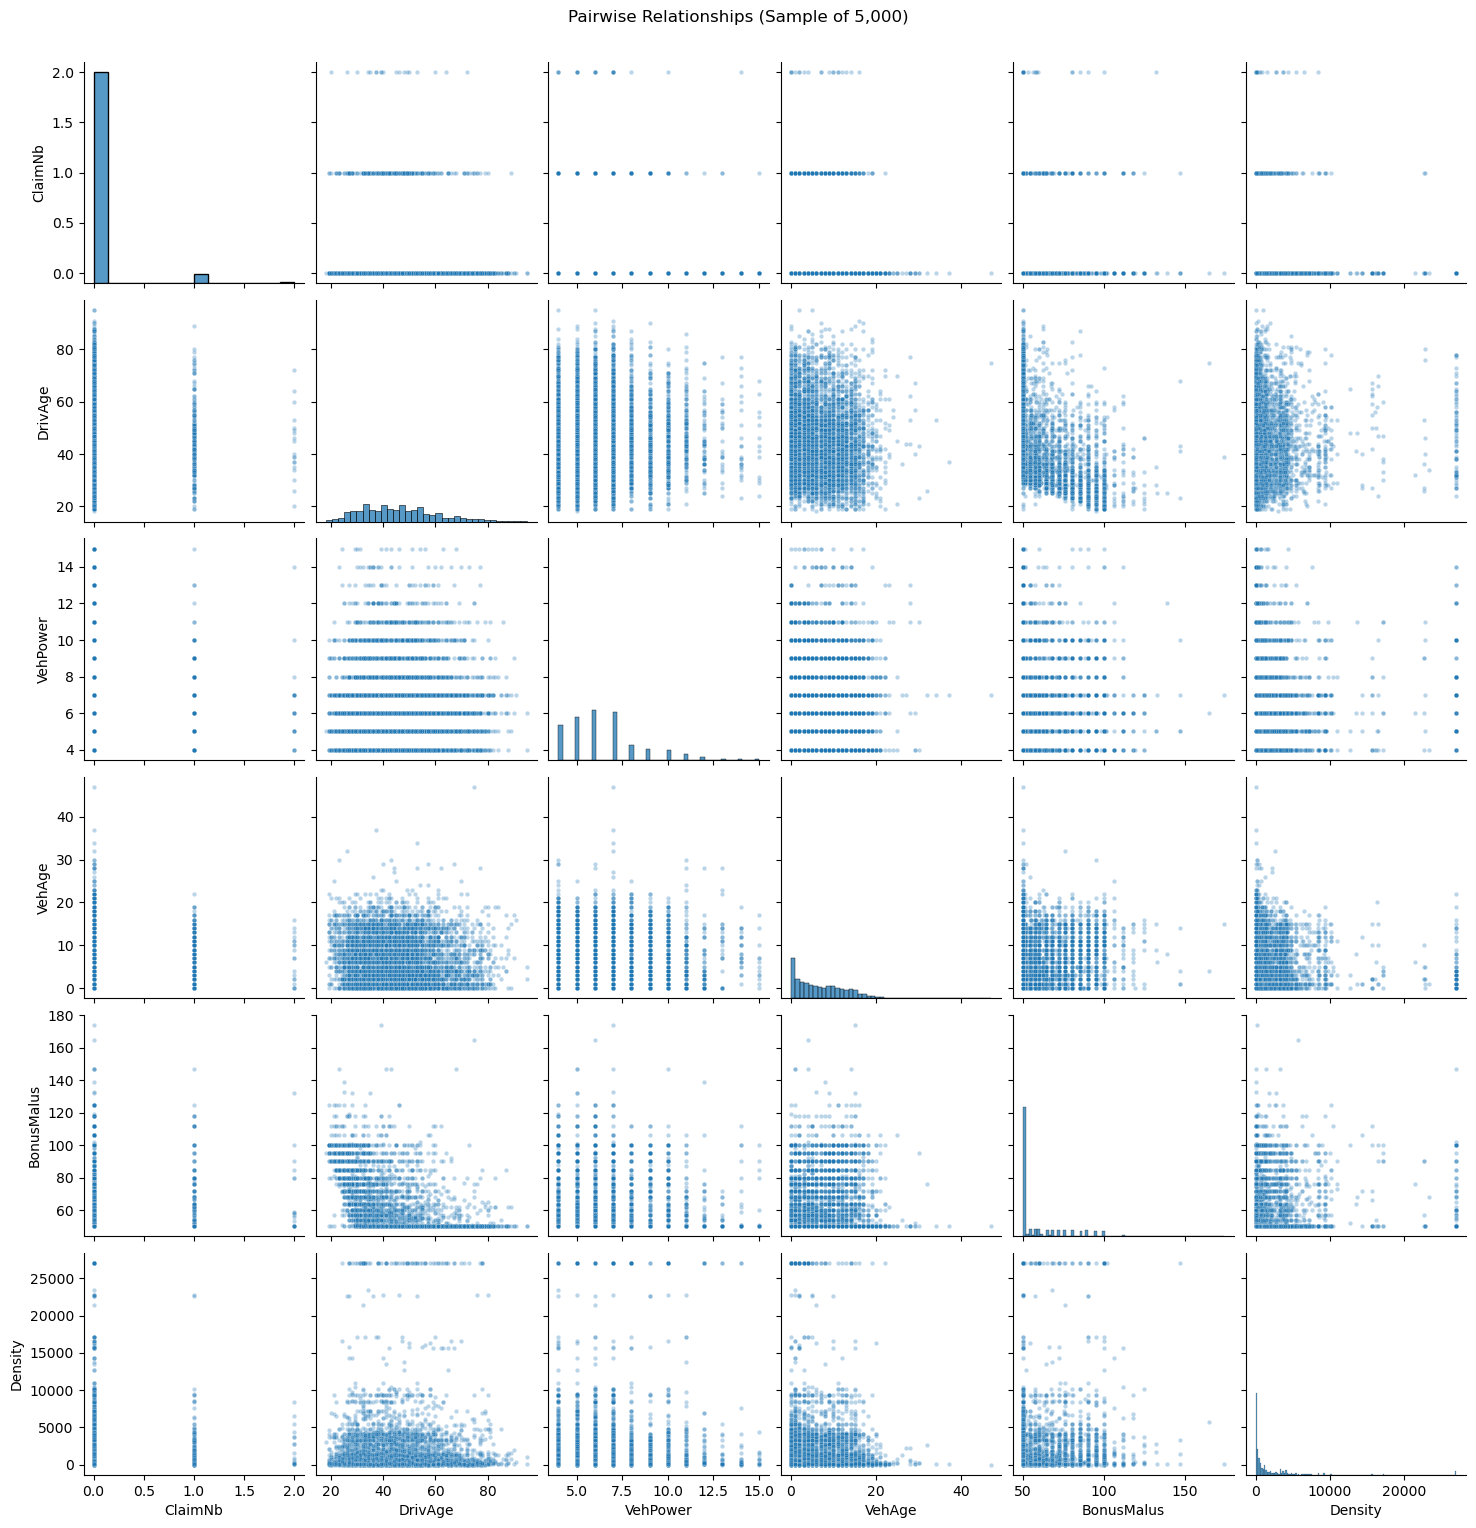

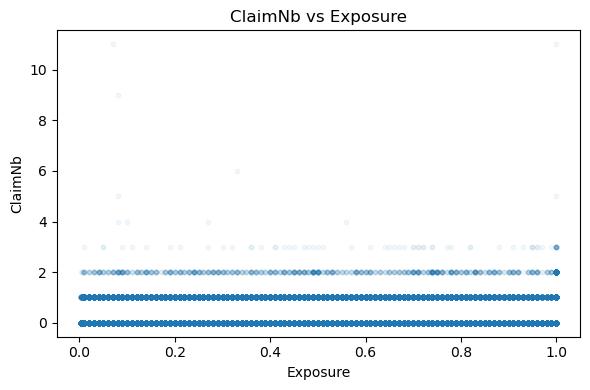

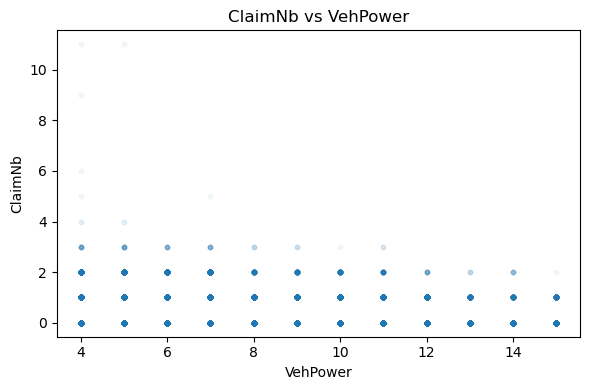

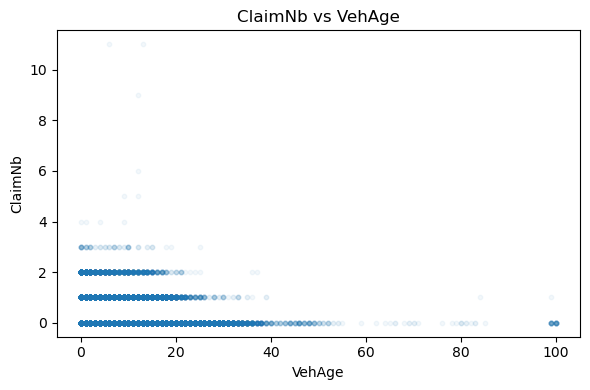

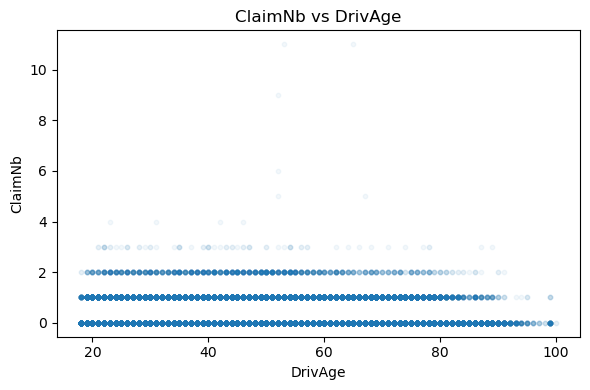

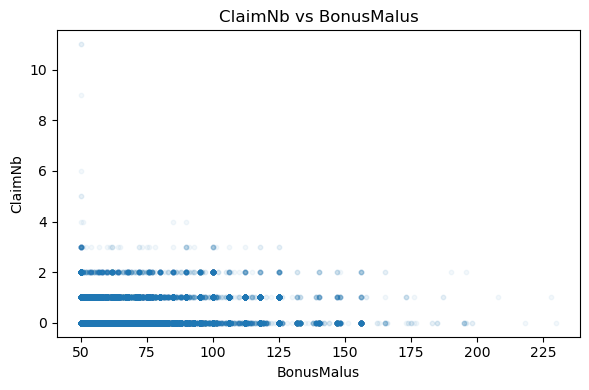

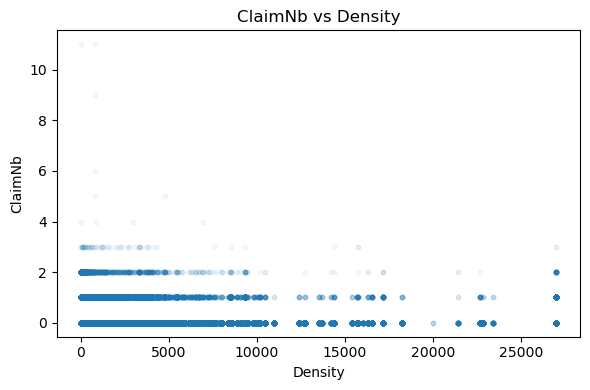

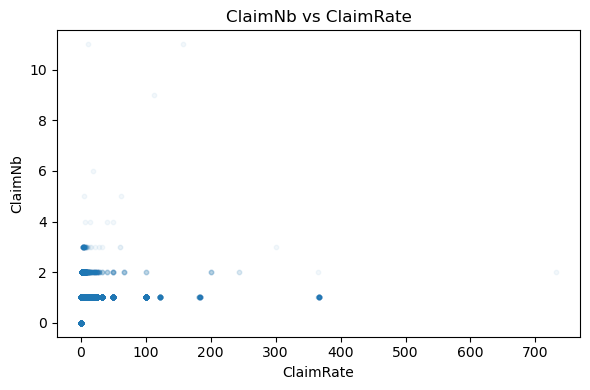

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load cleaned data
df = pd.read_csv("./data/claims_train_clean.csv")

# -----------------------------
# Prepare numeric subset
# -----------------------------
numeric_cols = ["ClaimNb", "Exposure", "VehPower", "VehAge",
                "DrivAge", "BonusMalus", "Density"]

# -----------------------------
# Correlation matrix
# -----------------------------
corr = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)

plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()

# -----------------------------
# Pairwise scatterplots (focus on key features)
# -----------------------------
import seaborn as sns

key_features = ["ClaimNb", "DrivAge", "VehPower", "VehAge",
                "BonusMalus", "Density"]

sns.pairplot(df[key_features].sample(5000, random_state=1), 
             diag_kind="hist", 
             plot_kws={"alpha": 0.3, "s": 10})

plt.suptitle("Pairwise Relationships (Sample of 5,000)", y=1.02)
plt.show()

# -----------------------------
# ClaimNb relationship with each numeric feature
# -----------------------------
for col in numeric_cols:
    if col == "ClaimNb":
        continue
    
    plt.figure(figsize=(6,4))
    plt.scatter(df[col], df["ClaimNb"], alpha=0.05, s=10)
    plt.xlabel(col)
    plt.ylabel("ClaimNb")
    plt.title(f"ClaimNb vs {col}")
    plt.tight_layout()
    plt.show()


In [45]:
# Load the cleaned dataset
df = pd.read_csv("./data/claims_train_clean.csv")

# Numeric columns for correlation
numeric_cols = ["ClaimNb", "ClaimRate", "Exposure", "VehPower", "VehAge",
                "DrivAge", "BonusMalus", "Density"]

# Compute correlation matrix
corr = df[numeric_cols].corr()

# Correlation rankings (absolute correlations)
corr_claimnb = corr["ClaimNb"].abs().sort_values(ascending=False)
corr_claimrate = corr["ClaimRate"].abs().sort_values(ascending=False)

print("\n=== Correlation Ranking with ClaimNb ===")
print(corr_claimnb)

print("\n=== Correlation Ranking with ClaimRate ===")
print(corr_claimrate)



=== Correlation Ranking with ClaimNb ===
ClaimNb       1.000000
ClaimRate     0.263654
Exposure      0.069604
BonusMalus    0.049692
VehAge        0.022288
DrivAge       0.011447
Density       0.011441
VehPower      0.004641
Name: ClaimNb, dtype: float64

=== Correlation Ranking with ClaimRate ===
ClaimRate     1.000000
ClaimNb       0.263654
Exposure      0.052659
VehAge        0.023968
BonusMalus    0.013860
Density       0.005873
DrivAge       0.003342
VehPower      0.001416
Name: ClaimRate, dtype: float64


In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder

# -------------------------------------------------
# 1. Load data
# -------------------------------------------------
df = pd.read_csv("./data/claims_train_clean.csv")

# Optional: sanity check
print("Shape:", df.shape)

# -------------------------------------------------
# 2. Targets
# -------------------------------------------------
# Claim count (regression target)
y_count = df["ClaimNb"].values

# Claim occurrence (classification target)
df["ClaimOccur"] = (df["ClaimNb"] > 0).astype(int)
y_occ = df["ClaimOccur"].values

# -------------------------------------------------
# 3. Features: numeric + categorical
# -------------------------------------------------
numeric_features = ["Exposure", "VehPower", "VehAge",
                   "DrivAge", "BonusMalus", "Density"]

categorical_features = ["Area", "VehBrand", "VehGas", "Region"]

X_num = df[numeric_features].reset_index(drop=True)

# One-hot encode categorical features
enc = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

X_cat = enc.fit_transform(df[categorical_features])

cat_feature_names = enc.get_feature_names_out(categorical_features)

# Combine numeric + categorical
X_all = np.hstack([X_num.values, X_cat])

all_feature_names = numeric_features + list(cat_feature_names)

print("Total features after encoding:", len(all_feature_names))

# -------------------------------------------------
# 4. Mutual Information for ClaimNb (regression)
# -------------------------------------------------
print("\n=== Mutual Information w.r.t ClaimNb (count) ===")
mi_count = mutual_info_regression(X_all, y_count, random_state=0)

mi_count_series = pd.Series(mi_count, index=all_feature_names)
mi_count_sorted = mi_count_series.sort_values(ascending=False)

print(mi_count_sorted.head(30))   # top 30 features

# -------------------------------------------------
# 5. Mutual Information for ClaimOccur (classification)
# -------------------------------------------------
print("\n=== Mutual Information w.r.t ClaimOccur (binary) ===")
mi_occ = mutual_info_classif(X_all, y_occ, random_state=0)

mi_occ_series = pd.Series(mi_occ, index=all_feature_names)
mi_occ_sorted = mi_occ_series.sort_values(ascending=False)

print(mi_occ_sorted.head(30))   # top 30 features

# -------------------------------------------------
# 6. Optional: save to CSV for inspection
# -------------------------------------------------
mi_df = pd.DataFrame({
    "feature": all_feature_names,
    "MI_ClaimNb": mi_count,
    "MI_ClaimOccur": mi_occ
})

mi_df_sorted_nb = mi_df.sort_values(by="MI_ClaimNb", ascending=False)
mi_df_sorted_occ = mi_df.sort_values(by="MI_ClaimOccur", ascending=False)

mi_df_sorted_nb.to_csv("./data/mutual_information_claimnb.csv", index=False)
mi_df_sorted_occ.to_csv("./data/mutual_information_claimoccur.csv", index=False)

print("\nSaved MI rankings to:")
print(" - ./data/mutual_information_claimnb.csv")
print(" - ./data/mutual_information_claimoccur.csv")


Shape: (541416, 13)
Total features after encoding: 47

=== Mutual Information w.r.t ClaimNb (count) ===
BonusMalus       0.003876
Exposure         0.002493
Region_R91       0.002352
Region_R93       0.002071
Region_R43       0.001990
VehBrand_B4      0.001864
Region_R54       0.001707
Region_R94       0.001403
Region_R23       0.001400
Region_R31       0.001268
VehBrand_B5      0.001190
VehBrand_B6      0.000876
Region_R24       0.000860
VehBrand_B2      0.000821
Area_F           0.000764
VehBrand_B12     0.000681
VehBrand_B3      0.000678
Area_A           0.000622
Density          0.000420
Region_R53       0.000411
Region_R25       0.000338
VehGas_Diesel    0.000333
VehPower         0.000333
VehBrand_B11     0.000317
Region_R74       0.000207
Region_R73       0.000110
Region_R72       0.000064
Region_R26       0.000012
Region_R82       0.000000
Region_R42       0.000000
dtype: float64

=== Mutual Information w.r.t ClaimOccur (binary) ===
VehGas_Regular    0.080770
VehGas_Diesel     0.